In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=500,wait_patience=3, debug=False, tracker='tracker.xlsx', comment='',
             tracker_update=True):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    pre_tr_acc = hist.history.get('accuracy')[len(hist.history.get('accuracy'))-1]
    # print(round(pre_tr_acc, 4))
    pre_val_acc = hist.history.get('val_accuracy')[len(hist.history.get('val_accuracy'))-1]
    # print(round(pre_val_acc, 4))
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, 
                      lr_rate=lr_rate, wait_patience=wait_patience, optimizer=optimizer,
                     pretrain_hist=hist)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)    
    loss = oset.losses[len(oset.losses)-1].numpy()    
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [oset.epoch], 'wait_patience': [wait_patience], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'pre_tr_acc': pre_tr_acc, 'pre_val_acc': pre_val_acc,'comment': comment}
    
    if tracker_update:
        update_tracker(tracker, tracker_data)
    return test_data, oset, hist

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
187/187 [==============================] - 18s 93ms/step - loss: 0.0672 - accuracy: 0.9793 - precision: 0.9882 - recall: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/6
187/187 [==============================] - 17s 90ms/step - loss: 0.0021 - accuracy: 0.9992 - precision: 0.9993 - recall: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/6
187/187 [==============================] - 17s 90ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1871e-05 - val_accuracy: 1.0000

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.74it/s]


epoch: 1/500, train_loss: 2.7133829593658447, F1_train: 0.6429361007454664 F1_val: 0.6739130434782609


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.74it/s]


epoch: 2/500, train_loss: 2.7121026515960693, F1_train: 0.934016462337945 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.77it/s]


epoch: 3/500, train_loss: 2.7084109783172607, F1_train: 0.9376485578123753 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.73it/s]


epoch: 4/500, train_loss: 2.714592218399048, F1_train: 0.9384131678103466 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.77it/s]


epoch: 5/500, train_loss: 2.7129995822906494, F1_train: 0.9392645836920088 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 6/500, train_loss: 2.7126104831695557, F1_train: 0.9402627018703865 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.59it/s]


epoch: 7/500, train_loss: 2.710394859313965, F1_train: 0.9414303968633098 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 8/500, train_loss: 2.712339162826538, F1_train: 0.9427691376231657 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.60it/s]


epoch: 9/500, train_loss: 2.713240385055542, F1_train: 0.943686992021216 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.28it/s]


epoch: 10/500, train_loss: 2.707228660583496, F1_train: 0.949070261225878 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 11/500, train_loss: 2.712672710418701, F1_train: 0.9492998035547819 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.36it/s]


epoch: 12/500, train_loss: 2.7084295749664307, F1_train: 0.9505076878595763 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.59it/s]


epoch: 13/500, train_loss: 2.7145142555236816, F1_train: 0.950500338581355 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.56it/s]


epoch: 14/500, train_loss: 2.711582660675049, F1_train: 0.9507278764075925 F1_val: 1.0


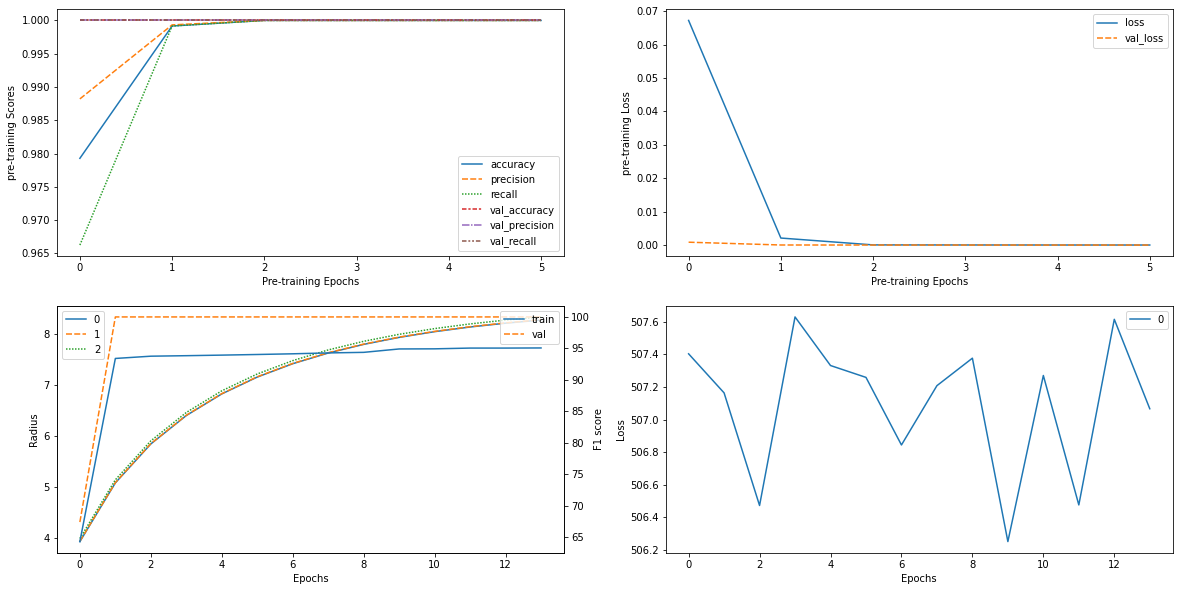

[[243   0   0   0]
 [  0 233   0  13]
 [  0   0 236   9]
 [  0   0   0 162]]
97.54
f1_weighted: 0.9759361754411993, f1_macro: 0.97264132288026, f1_micro: 0.9754464285714286, f_measure: {'Known': 98.4716, 'Open': 93.6416, 'F1-score': 97.2641}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      0.95      0.97       246
           2       1.00      0.96      0.98       245
           5       0.88      1.00      0.94       162

    accuracy                           0.98       896
   macro avg       0.97      0.98      0.97       896
weighted avg       0.98      0.98      0.98       896



padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
187/187 [==============================] - 18s 94ms/step - loss: 0.0791 - accuracy: 0.9686 - precision_1: 0.9839 - recall_1: 0.9614 - val_loss: 9.8174e-05 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/6
187/187 [==============================] - 17s 92ms/step - loss: 0.0025 - accuracy: 0.9992 - precision_1: 0.9992 - recall_1: 0.9992 - val_loss: 0.0013 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/6
187/187 [==============================] - 18s 95ms/step - loss: 5.5095e-04 - accuracy: 0.9998 - precision_1: 0.9998 - recall_1: 0.9998 - val_loss: 1.9109e-05 - val_

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.63it/s]


epoch: 1/500, train_loss: 3.6135730743408203, F1_train: 0.6118707640222315 F1_val: 0.6739130434782609


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.38it/s]


epoch: 2/500, train_loss: 3.6122701168060303, F1_train: 0.6333285927225322 F1_val: 0.6644021739130435


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.39it/s]


epoch: 3/500, train_loss: 3.607152223587036, F1_train: 0.6496210282311712 F1_val: 0.6698369565217391


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.57it/s]


epoch: 4/500, train_loss: 3.614511728286743, F1_train: 0.9271438723879457 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.41it/s]


epoch: 5/500, train_loss: 3.613614797592163, F1_train: 0.9313947167954106 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.49it/s]


epoch: 6/500, train_loss: 3.613576650619507, F1_train: 0.933223267116192 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:27<00:00,  6.74it/s]


epoch: 7/500, train_loss: 3.6099853515625, F1_train: 0.9338619630003496 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.48it/s]


epoch: 8/500, train_loss: 3.6130471229553223, F1_train: 0.9347467744092317 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.47it/s]


epoch: 9/500, train_loss: 3.61478590965271, F1_train: 0.9347887669972544 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.33it/s]


epoch: 10/500, train_loss: 3.607658863067627, F1_train: 0.9349666132968313 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.31it/s]


epoch: 11/500, train_loss: 3.6126060485839844, F1_train: 0.9352146823198105 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.45it/s]


epoch: 12/500, train_loss: 3.606734275817871, F1_train: 0.9357921360797613 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.32it/s]


epoch: 13/500, train_loss: 3.615107297897339, F1_train: 0.9357804492311029 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.40it/s]


epoch: 14/500, train_loss: 3.610823631286621, F1_train: 0.9410181113292099 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.51it/s]


epoch: 15/500, train_loss: 3.6140573024749756, F1_train: 0.941401551381824 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.42it/s]


epoch: 16/500, train_loss: 3.6106557846069336, F1_train: 0.9411870668555953 F1_val: 1.0


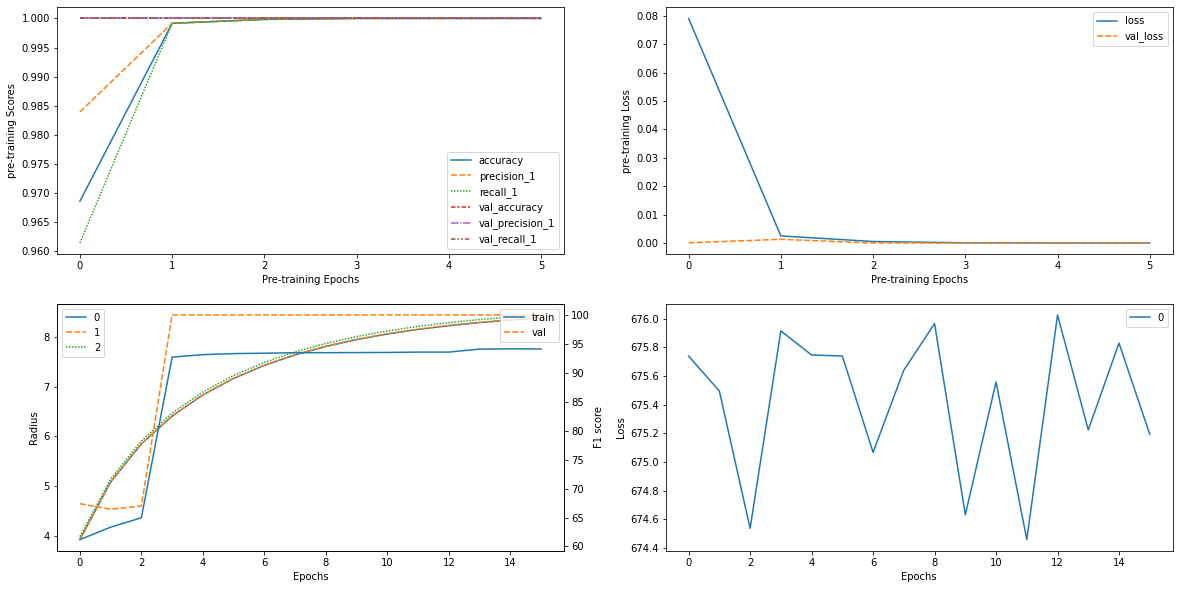

[[243   0   0   0]
 [  0 235   0  11]
 [  0   0 236   9]
 [ 11   0   0 151]]
96.54
f1_weighted: 0.9657708371553946, f1_macro: 0.9607985171365454, f1_micro: 0.9654017857142857, f_measure: {'Known': 97.8762, 'Open': 90.6907, 'F1-score': 96.0799}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       243
           1       1.00      0.96      0.98       246
           2       1.00      0.96      0.98       245
           5       0.88      0.93      0.91       162

    accuracy                           0.97       896
   macro avg       0.96      0.96      0.96       896
weighted avg       0.97      0.97      0.97       896



In [3]:
comment="waiting did not help, what about increasing em size?"
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=14,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=6, wait_patience=12, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
187/187 [==============================] - 18s 96ms/step - loss: 0.2779 - accuracy: 0.8100 - precision_2: 0.9573 - recall_2: 0.7801 - val_loss: 0.0018 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 2/6
187/187 [==============================] - 17s 93ms/step - loss: 0.0035 - accuracy: 0.9985 - precision_2: 0.9985 - recall_2: 0.9985 - val_loss: 3.7761e-05 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 3/6
187/187 [==============================] - 17s 90ms/step - loss: 3.6368e-04 - accuracy: 0.9998 - precision_2: 0.9998 - recall_2: 0.9998 - val_loss: 6.3457e-06 - val_

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 1/500, train_loss: 8.378499984741211, F1_train: 0.5602257670388966 F1_val: 0.6739130434782609


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 2/500, train_loss: 8.373793601989746, F1_train: 0.5789968211807899 F1_val: 0.6644021739130435


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:27<00:00,  6.89it/s]


epoch: 3/500, train_loss: 8.360921859741211, F1_train: 0.5849341427354927 F1_val: 0.6698369565217391


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.26it/s]


epoch: 4/500, train_loss: 8.380928993225098, F1_train: 0.5890104774067343 F1_val: 0.6657608695652174


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.18it/s]


epoch: 5/500, train_loss: 8.376873016357422, F1_train: 0.5925147673289777 F1_val: 0.6657608695652174


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.02it/s]


epoch: 6/500, train_loss: 8.379820823669434, F1_train: 0.5951204563662694 F1_val: 0.6698369565217391


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.36it/s]


epoch: 7/500, train_loss: 8.368149757385254, F1_train: 0.5989252822929436 F1_val: 0.6711956521739131


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.70it/s]


epoch: 8/500, train_loss: 8.377232551574707, F1_train: 0.6026552167968258 F1_val: 0.6671195652173914


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.40it/s]


epoch: 9/500, train_loss: 8.380520820617676, F1_train: 0.6058812769896389 F1_val: 0.6657608695652174


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:23<00:00,  7.80it/s]


epoch: 10/500, train_loss: 8.359265327453613, F1_train: 0.6101608075352625 F1_val: 0.6671195652173914


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.72it/s]


epoch: 11/500, train_loss: 8.375394821166992, F1_train: 0.6128484507912983 F1_val: 0.6711956521739131


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.62it/s]


epoch: 12/500, train_loss: 8.362043380737305, F1_train: 0.6144268162587024 F1_val: 0.6644021739130435


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.40it/s]


epoch: 13/500, train_loss: 8.383209228515625, F1_train: 0.615422136601727 F1_val: 0.6671195652173914


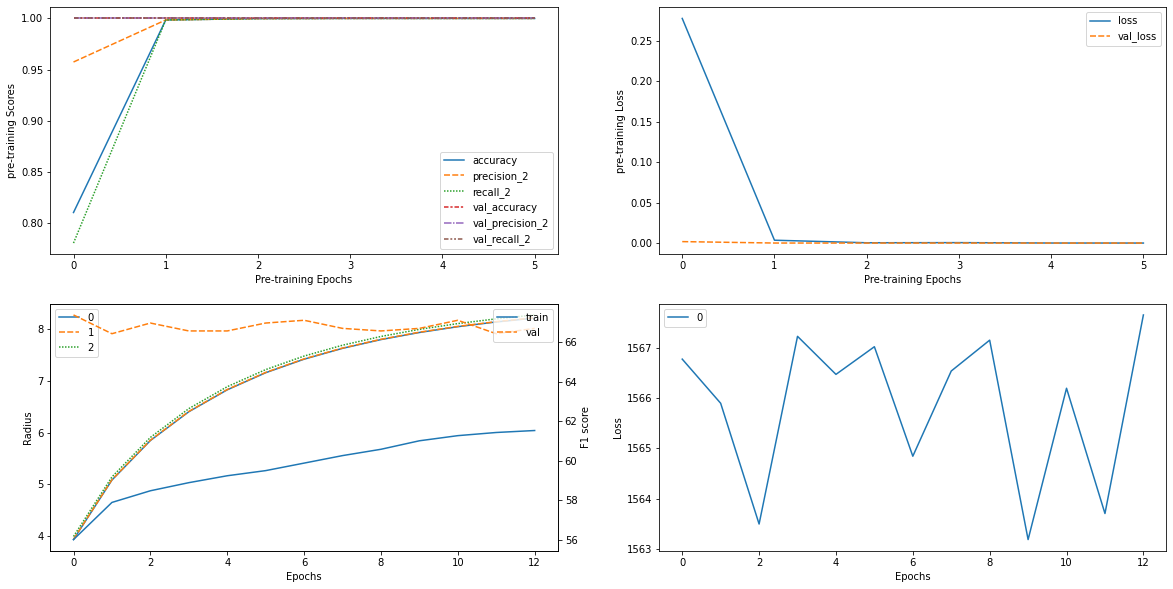

[[243   0   0   0]
 [  0   0   0 246]
 [  0   0 212  33]
 [  0   0   0 162]]
68.86
f1_weighted: 0.6220461049511741, f1_macro: 0.6162758417975767, f1_micro: 0.6886160714285714, f_measure: {'Known': 64.2597, 'Open': 53.7313, 'F1-score': 61.6276}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       0.00      0.00      0.00       246
           2       1.00      0.87      0.93       245
           5       0.37      1.00      0.54       162

    accuracy                           0.69       896
   macro avg       0.59      0.72      0.62       896
weighted avg       0.61      0.69      0.62       896



In [4]:
comment="em size increase did not help, what about decreasing em size?"
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=10,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=6, wait_patience=12, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
187/187 [==============================] - 19s 100ms/step - loss: 0.0672 - accuracy: 0.9793 - precision_3: 0.9882 - recall_3: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 2/6
187/187 [==============================] - 18s 96ms/step - loss: 0.0021 - accuracy: 0.9992 - precision_3: 0.9993 - recall_3: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 3/6
187/187 [==============================] - 18s 97ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 1.1871e-05 -

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.35it/s]


epoch: 1/500, train_loss: 2.7133829593658447, F1_train: 0.6480854974718288 F1_val: 0.6739130434782609


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.33it/s]


epoch: 2/500, train_loss: 2.7121026515960693, F1_train: 0.9354070080838464 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.37it/s]


epoch: 3/500, train_loss: 2.7084109783172607, F1_train: 0.9377324288139305 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.36it/s]


epoch: 4/500, train_loss: 2.714592218399048, F1_train: 0.938580699947614 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.14it/s]


epoch: 5/500, train_loss: 2.7129995822906494, F1_train: 0.9400464958778197 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.38it/s]


epoch: 6/500, train_loss: 2.7126104831695557, F1_train: 0.9413047105087042 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.33it/s]


epoch: 7/500, train_loss: 2.710394859313965, F1_train: 0.9432061187225248 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.19it/s]


epoch: 8/500, train_loss: 2.712339162826538, F1_train: 0.9439959736807861 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.19it/s]


epoch: 9/500, train_loss: 2.713240385055542, F1_train: 0.9496395694673805 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.31it/s]


epoch: 10/500, train_loss: 2.707228660583496, F1_train: 0.9505076878700732 F1_val: 1.0


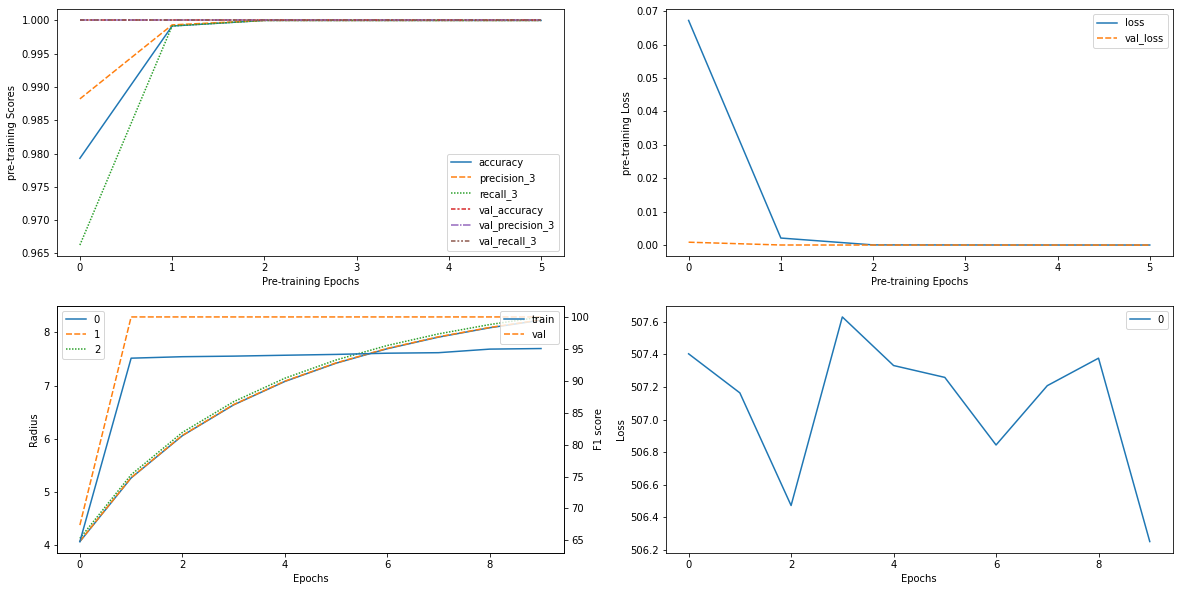

[[243   0   0   0]
 [  0 233   0  13]
 [  0   0 240   5]
 [  0   0   0 162]]
97.99
f1_weighted: 0.9802137297196946, f1_macro: 0.977479816990769, f1_micro: 0.9799107142857143, f_measure: {'Known': 98.7517, 'Open': 94.7368, 'F1-score': 97.748}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      0.95      0.97       246
           2       1.00      0.98      0.99       245
           5       0.90      1.00      0.95       162

    accuracy                           0.98       896
   macro avg       0.97      0.98      0.98       896
weighted avg       0.98      0.98      0.98       896



In [5]:
comment="restroing em size to 12, increasing the lr rate a bit "
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=6, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
187/187 [==============================] - 19s 95ms/step - loss: 0.0672 - accuracy: 0.9793 - precision: 0.9882 - recall: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/6
187/187 [==============================] - 17s 94ms/step - loss: 0.0021 - accuracy: 0.9992 - precision: 0.9993 - recall: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/6
187/187 [==============================] - 18s 97ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1871e-05 - val_accuracy: 1.0000

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.64it/s]


epoch: 1/500, train_loss: 2.7133829593658447, F1_train: 0.6480854974718288 F1_val: 0.6739130434782609


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 2/500, train_loss: 2.7121026515960693, F1_train: 0.9354070080838464 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.56it/s]


epoch: 3/500, train_loss: 2.7084109783172607, F1_train: 0.9377324288139305 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.44it/s]


epoch: 4/500, train_loss: 2.714592218399048, F1_train: 0.938580699947614 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 5/500, train_loss: 2.7129995822906494, F1_train: 0.9400464958778197 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 6/500, train_loss: 2.7126104831695557, F1_train: 0.9413047105087042 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 7/500, train_loss: 2.710394859313965, F1_train: 0.9432061187225248 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.49it/s]


epoch: 8/500, train_loss: 2.712339162826538, F1_train: 0.9439959736807861 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.35it/s]


epoch: 9/500, train_loss: 2.713240385055542, F1_train: 0.9496395694673805 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:26<00:00,  7.13it/s]


epoch: 10/500, train_loss: 2.707228660583496, F1_train: 0.9505076878700732 F1_val: 1.0


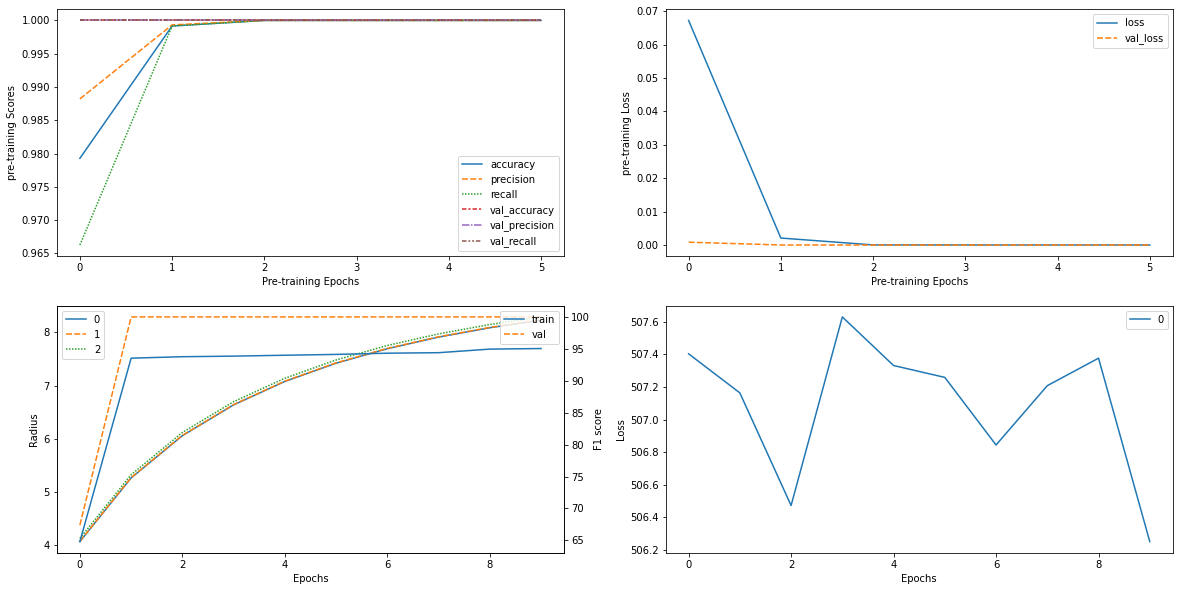

[[243   0   0   0]
 [  0 233   0  13]
 [  0   0 240   5]
 [  0   0   0 162]]
97.99
f1_weighted: 0.9802137297196946, f1_macro: 0.977479816990769, f1_micro: 0.9799107142857143, f_measure: {'Known': 98.7517, 'Open': 94.7368, 'F1-score': 97.748}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      0.95      0.97       246
           2       1.00      0.98      0.99       245
           5       0.90      1.00      0.95       162

    accuracy                           0.98       896
   macro avg       0.97      0.98      0.98       896
weighted avg       0.98      0.98      0.98       896



In [3]:
comment="correcting the code for eval score and rerun "
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=6, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
187/187 [==============================] - 19s 96ms/step - loss: 0.0672 - accuracy: 0.9793 - precision_1: 0.9882 - recall_1: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/6
187/187 [==============================] - 18s 95ms/step - loss: 0.0021 - accuracy: 0.9992 - precision_1: 0.9993 - recall_1: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/6
187/187 [==============================] - 18s 95ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 1.1871e-05 - 

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 1/500, train_loss: 2.7133829593658447, F1_train: 0.6480854974718288 F1_val: 0.6739130434782609


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 2/500, train_loss: 2.7121026515960693, F1_train: 0.9354070080838464 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 3/500, train_loss: 2.7084109783172607, F1_train: 0.9377324288139305 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.50it/s]


epoch: 4/500, train_loss: 2.714592218399048, F1_train: 0.938580699947614 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:25<00:00,  7.45it/s]


epoch: 5/500, train_loss: 2.7129995822906494, F1_train: 0.9400464958778197 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 6/500, train_loss: 2.7126104831695557, F1_train: 0.9413047105087042 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 7/500, train_loss: 2.710394859313965, F1_train: 0.9432061187225248 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 8/500, train_loss: 2.712339162826538, F1_train: 0.9439959736807861 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.53it/s]


epoch: 9/500, train_loss: 2.713240385055542, F1_train: 0.9496395694673805 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 10/500, train_loss: 2.707228660583496, F1_train: 0.9505076878700732 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 11/500, train_loss: 2.712672710418701, F1_train: 0.9510648546746897 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 12/500, train_loss: 2.7084295749664307, F1_train: 0.952043706436441 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.54it/s]


epoch: 13/500, train_loss: 2.7145142555236816, F1_train: 0.9522552953792235 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.55it/s]


epoch: 14/500, train_loss: 2.711582660675049, F1_train: 0.9523712509090518 F1_val: 1.0


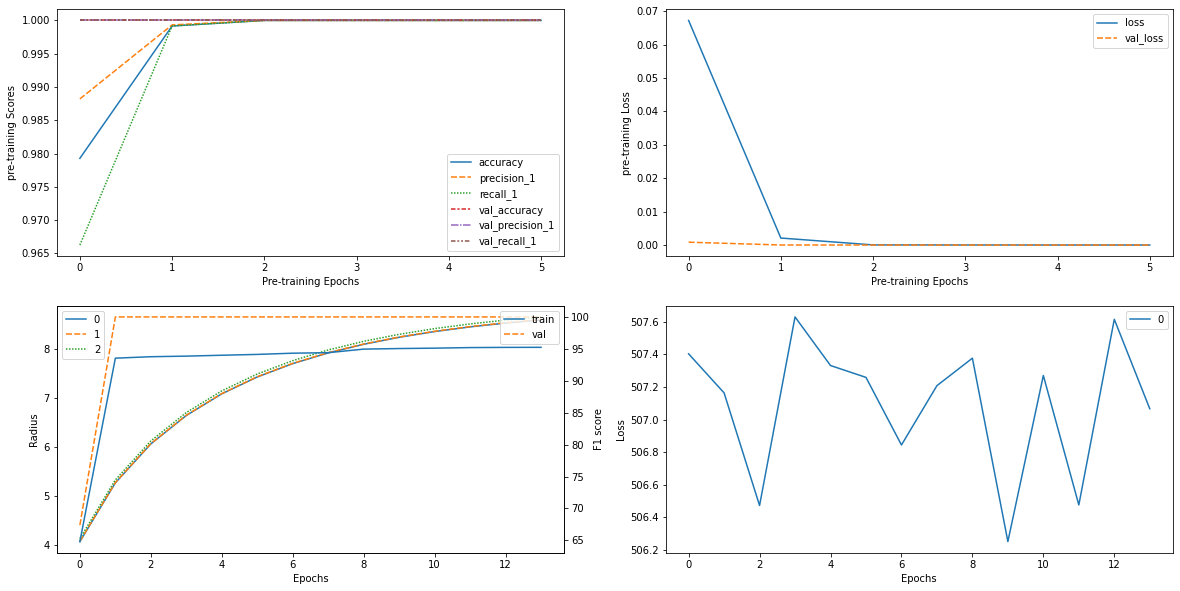

[[243   0   0   0]
 [  0 233   0  13]
 [  0   0 240   5]
 [  0   0   0 162]]
97.99
f1_weighted: 0.9802137297196946, f1_macro: 0.977479816990769, f1_micro: 0.9799107142857143, f_measure: {'Known': 98.7517, 'Open': 94.7368, 'F1-score': 97.748}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      0.95      0.97       246
           2       1.00      0.98      0.99       245
           5       0.90      1.00      0.95       162

    accuracy                           0.98       896
   macro avg       0.97      0.98      0.98       896
weighted avg       0.98      0.98      0.98       896



In [4]:
comment="wait logic need correction, as of now lets inciease the wait"
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=6, wait_patience=12, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2000
val_0:, 250
test_0:, 250
train_1:, 2000
val_1:, 250
test_1:, 250
train_2:, 2000
val_2:, 250
test_2:, 250
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/6
187/187 [==============================] - 18s 94ms/step - loss: 0.0672 - accuracy: 0.9793 - precision: 0.9882 - recall: 0.9662 - val_loss: 8.5805e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/6
187/187 [==============================] - 17s 93ms/step - loss: 0.0021 - accuracy: 0.9992 - precision: 0.9993 - recall: 0.9992 - val_loss: 2.3739e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/6
187/187 [==============================] - 17s 93ms/step - loss: 5.0672e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1871e-05 - val_accuracy: 1.0000

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.68it/s]


epoch: 1/500, train_loss: 2.7133829593658447, F1_train: 0.6480854974718288 F1_val: 0.6739130434782609


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.69it/s]


epoch: 2/500, train_loss: 2.7121026515960693, F1_train: 0.9354070080838464 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.69it/s]


epoch: 3/500, train_loss: 2.7084109783172607, F1_train: 0.9377324288139305 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.67it/s]


epoch: 4/500, train_loss: 2.714592218399048, F1_train: 0.938580699947614 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.69it/s]


epoch: 5/500, train_loss: 2.7129995822906494, F1_train: 0.9400464958778197 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.67it/s]


epoch: 6/500, train_loss: 2.7126104831695557, F1_train: 0.9413047105087042 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.68it/s]


epoch: 7/500, train_loss: 2.710394859313965, F1_train: 0.9432061187225248 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:24<00:00,  7.69it/s]


epoch: 8/500, train_loss: 2.712339162826538, F1_train: 0.9439959736807861 F1_val: 1.0


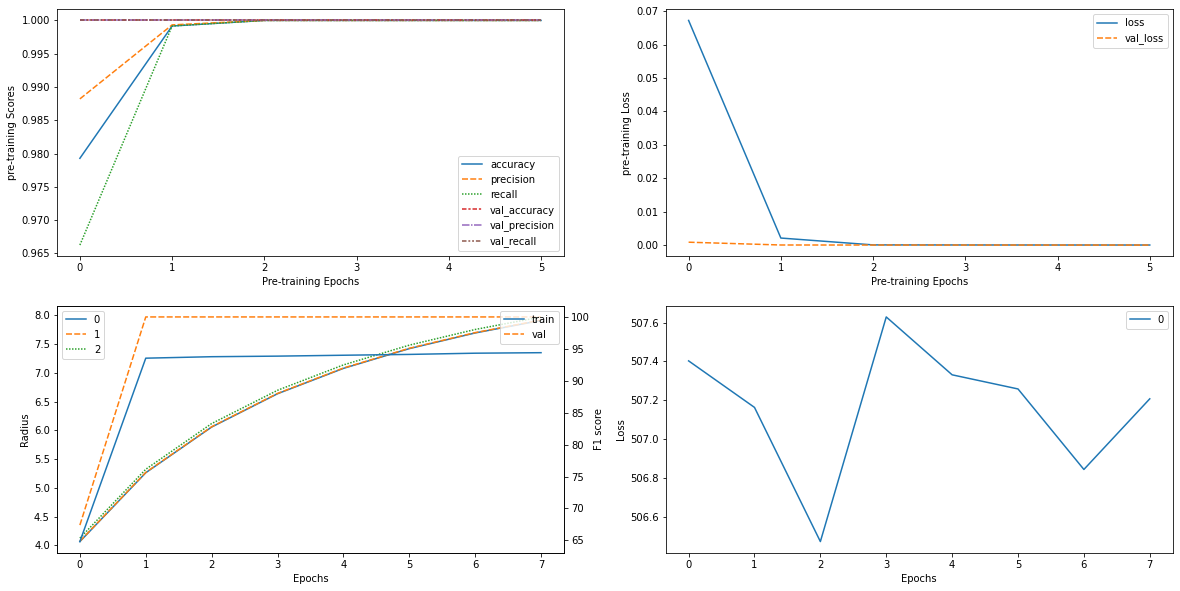

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [2]:
comment="change_1 wait logic"
test_data, oset, hist = oset_train(ablation=2500,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=6, wait_patience=8, comment=comment)